In [2]:
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Data source import complete.


# Sentitment analysis using simple machine learning model : Naive bayes 

In [3]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
# from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer, BertModel

In [14]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [15]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')


In [16]:
train_df.head(2)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105


In [17]:
test_df.head(2)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0


# Data preprocessing 

## Handling missing values 

In [18]:
def handle_null_values(df, columns_to_keep=None):
    """
    Handle null values in a pandas DataFrame.
    If missing values are less than 5%, remove rows with missing values.
    If missing values are 5% or more, keep rows where specified columns are not empty.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns_to_keep (list): List of column names to prioritize when keeping rows.

    Returns:
    pd.DataFrame: The DataFrame with null values handled.
    """

    # Calculate the percentage of missing values in the DataFrame
    missing_percentage = df.isnull().mean().mean() * 100

    print(f"Percentage of missing values in the dataset: {missing_percentage:.4f}%")

    # If missing values are less than 5%, remove rows with missing values
    if missing_percentage < 5:
        print("Missing values are less than 5%. Removing rows with missing values...")
        df_cleaned = df.dropna()
        print(f"Number of rows removed: {len(df) - len(df_cleaned)}")
    else:
        print("Missing values are 5% or more. Keeping rows where specified columns are not empty...")
        if columns_to_keep is None:
            print("No columns specified to keep. Returning the original DataFrame.")
            df_cleaned = df
        else:
            # Keep rows where the specified columns are not null
            df_cleaned = df.dropna(subset=columns_to_keep)
            print(f"Number of rows removed: {len(df) - len(df_cleaned)}")

    return df_cleaned

In [19]:
train_df = handle_null_values(train_df)

Percentage of missing values in the dataset: 0.0007%
Missing values are less than 5%. Removing rows with missing values...
Number of rows removed: 1


In [20]:
test_df=handle_null_values(test_df,columns_to_keep=["text","sentiment"])

Percentage of missing values in the dataset: 26.6044%
Missing values are 5% or more. Keeping rows where specified columns are not empty...
Number of rows removed: 1281


### Removing stopwords & lowercase all text

In [21]:
# Download necessary NLTK data
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
my_stopwords = stopwords.words('english').copy()

In [23]:
stopwords_to_keep = {
    'not', 'no', 'nor', "don't", "isn't", "aren't", "couldn't", "didn't", "doesn't",
    "hadn't", "hasn't", "haven't", "mightn't", "mustn't", "needn't", "shouldn't",
    "wasn't", "weren't", "won't", "wouldn't", 'but', 'however', 'although', 'though'
}

In [24]:
my_stopwords = list(set(my_stopwords) - stopwords_to_keep)
my_stopwords

['the',
 'until',
 'has',
 'over',
 "she'll",
 'those',
 "i'll",
 'because',
 'few',
 'into',
 'after',
 'below',
 "they'd",
 'some',
 'don',
 'am',
 'having',
 'y',
 'yourself',
 "they're",
 'd',
 'and',
 'my',
 'same',
 'where',
 'didn',
 'her',
 "you'll",
 'we',
 'against',
 't',
 'ma',
 'through',
 "it'd",
 'i',
 'was',
 'does',
 'were',
 'myself',
 'then',
 'very',
 "we'll",
 'do',
 'both',
 're',
 'too',
 'they',
 'down',
 'have',
 'why',
 'which',
 'isn',
 "it'll",
 'again',
 "it's",
 'it',
 've',
 'if',
 'who',
 "that'll",
 'wouldn',
 'should',
 "they'll",
 'between',
 'while',
 'hasn',
 'his',
 'to',
 'ourselves',
 "we've",
 "i'd",
 'above',
 'itself',
 'been',
 'during',
 'haven',
 'how',
 'aren',
 'm',
 'its',
 'off',
 "they've",
 'him',
 'further',
 'theirs',
 'them',
 'whom',
 'weren',
 'she',
 'mightn',
 'there',
 'o',
 'a',
 'on',
 'or',
 'up',
 'me',
 'that',
 'did',
 'needn',
 'he',
 "you've",
 'themselves',
 'can',
 'couldn',
 "he'd",
 'what',
 'yours',
 "she's",
 'of

In [25]:
import re 

In [26]:
print(re.sub(r'\s+', ' ', "testing how,  this goes!   lol ?    "))

testing how, this goes! lol ? 


In [28]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = my_stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    text= re.sub(r'https?://[A-Za-z0-9./_?=#]+'," ",text) #supprimer les liens
    text = re.sub(r"[^a-zA-Z0-9\s!?*$]", "", text) # supprimer la ponctuation
    text = re.sub(r'\s+', ' ', text) # supprimer les doubles espaces
    return text

In [29]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,sons **** couldnt put releases already bought


In [30]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,like it!!


In [31]:
# Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
sentiment_reverse_mapping = {2: "positive",1:"neutral", 0:"negative"}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)



In [32]:
# Filters
negatives=train_df['sentiment']=="negative"
positives=train_df['sentiment']=="positive"
neutrals = train_df["sentiment"]=="neutral"

In [33]:
train_df["len"] = train_df["processed_text"].apply(lambda x: len(x.split()))

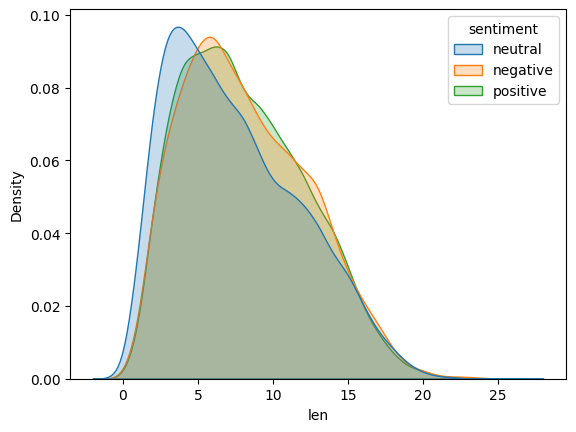

In [34]:
sns.kdeplot(data=train_df,x="len",hue="sentiment",fill=True, common_norm=False)
plt.show()

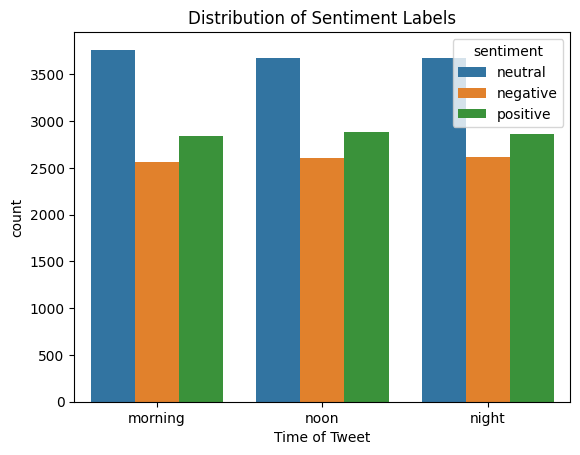

In [35]:
sns.countplot(x='Time of Tweet', data=train_df, hue="sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

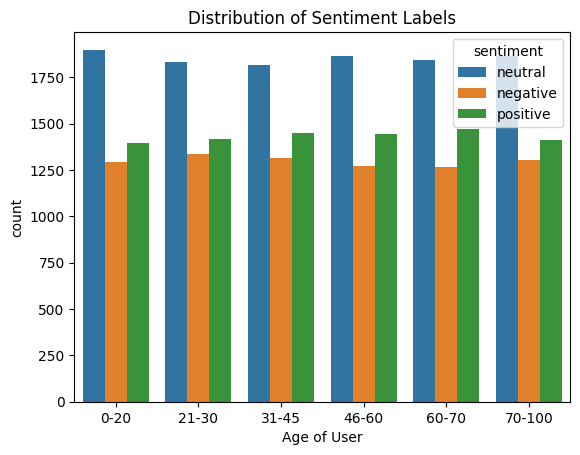

In [36]:
sns.countplot(x='Age of User', data=train_df, hue="sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

In [37]:
from collections import Counter
top_pos =Counter(" ".join(train_df[positives]['processed_text']).split())
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter(" ".join(train_df[negatives]['processed_text']).split())
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

top_neu = Counter(" ".join(train_df[neutrals]['processed_text']).split())
top_neu_df=pd.DataFrame(top_neu.most_common(100),columns=['Words','Counts'])

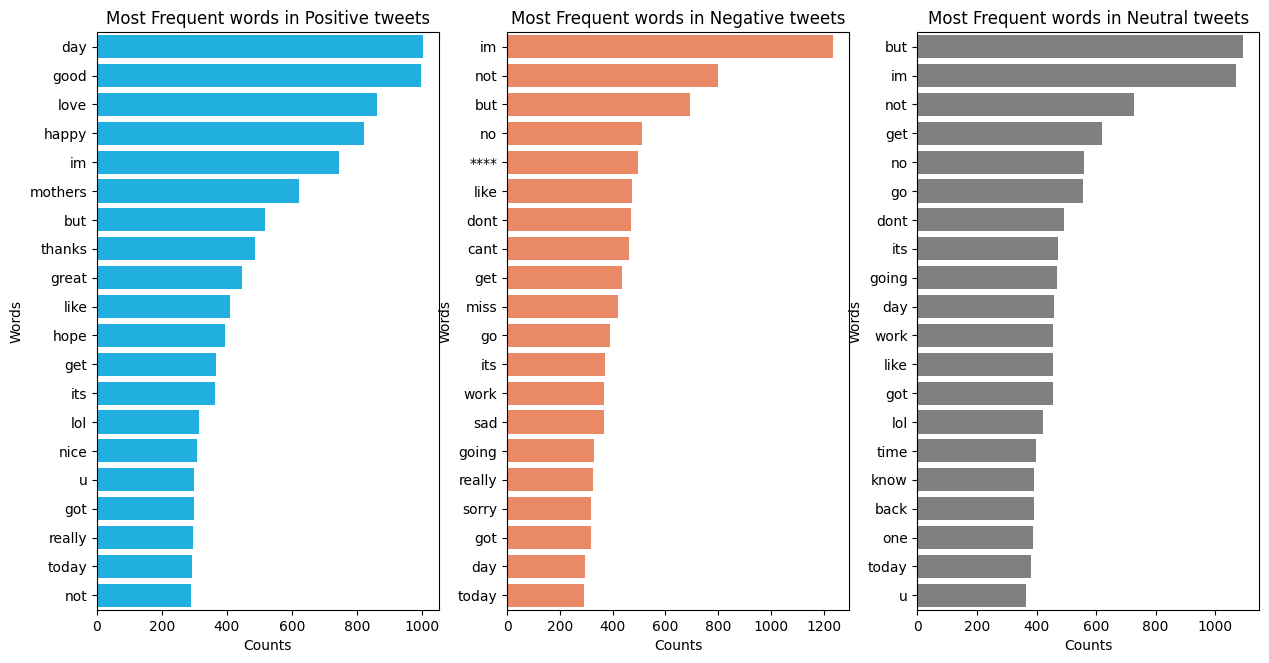

In [38]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,7.5))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
sns.barplot(y='Words',x='Counts',data=top_neu_df[:20],color='grey',ax=ax[2])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
ax[2].set_title("Most Frequent words in Neutral tweets")
plt.show()

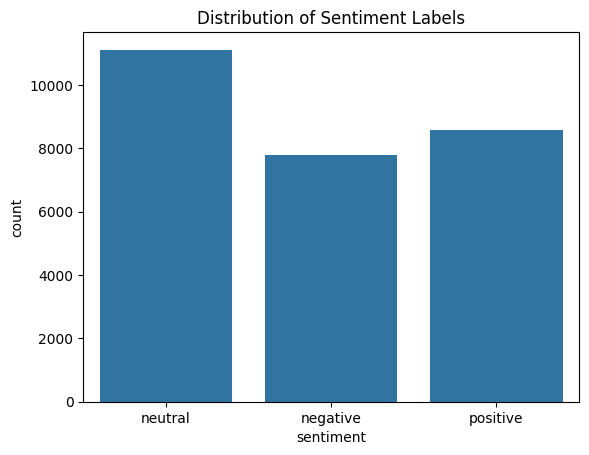

In [39]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [40]:
# Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.2, random_state=1770)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score

In [42]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,  # Ignorer les termes qui apparaissent dans moins de 5 documents
    max_df=0.95)
X_train_tfidf = tfidf.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf.transform(test_df['processed_text'])

models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',  # Spécifique pour multiclasse
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),  # Ajout d'un smoothing parameter
    'Linear SVM': LinearSVC(
        multi_class='ovr',  # one-vs-rest
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=10  # Limiter la profondeur pour éviter le surapprentissage
    )
}
results_tf = {}
for name, model in models.items():

    model.fit(X_train_tfidf, train_df["sentiment_class"])

    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(test_df["sentiment_class"], y_pred)
    results_tf[name] = {
        'accuracy': accuracy,
    }
for name in models.keys():
        print(f"\nRésultats pour {name}:")
        print(f"Accuracy: {results_tf[name]['accuracy']:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Résultats pour Logistic Regression:
Accuracy: 0.7049

Résultats pour Naive Bayes:
Accuracy: 0.6338

Résultats pour Linear SVM:
Accuracy: 0.6916

Résultats pour Random Forest:
Accuracy: 0.6409


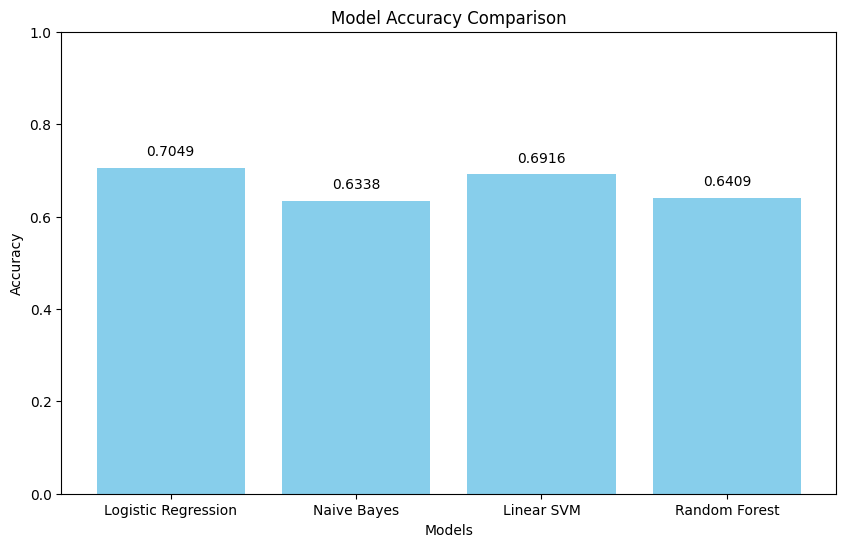

In [43]:
model_names = list(results_tf.keys())
accuracies = [results_tf[name]["accuracy"] for name in model_names]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color="skyblue")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center", va="bottom")

# Show the plot
plt.show()

In [44]:
print(len(trainval_x),len(val_x),len(test_x))

27480 5496 3534


In [49]:
from tqdm import tqdm
class TextDatasetWithEmbeddings(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, model, device):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of labels.
            tokenizer (transformers.BertTokenizer): BERT tokenizer.
            max_length (int): Maximum sequence length.
            model (transformers.BertModel): Pre-trained BERT model.
            device (torch.device): Device (CPU/GPU).
            use_pooler (bool): If True, use `pooler_output`; else, use `last_hidden_state[:, 0, :]`.
        """
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.model = model
        self.device = device

        # Tokenize all texts upfront
        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Precompute embeddings for all texts
        self.embeddings = self._precompute_embeddings()

    def _precompute_embeddings(self, batch_size=512):
        """Generates embeddings in batches to avoid GPU memory overload."""
        print("Generating embeddings in batches...")
        self.model.eval()
        self.model.to(self.device)

        # Get total number of samples
        num_samples = self.encodings["input_ids"].size(0)

        # Initialize tensor to store all embeddings
        all_embeddings = []

        # Process in batches
        for start_idx in tqdm(range(0, num_samples, batch_size)):
            end_idx = min(start_idx + batch_size, num_samples)

            # Get batch
            batch_input_ids = self.encodings["input_ids"][start_idx:end_idx].to(self.device)
            batch_attention_mask = self.encodings["attention_mask"][start_idx:end_idx].to(self.device)

            with torch.no_grad():
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )
                batch_embeddings = outputs.pooler_output
            all_embeddings.append(batch_embeddings.cpu())

        # Combine all batches
        return torch.cat(all_embeddings, dim=0)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """Returns precomputed embeddings and labels."""
        return self.embeddings[idx], self.labels[idx]

In [45]:
class TokenizedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]


In [46]:
MAX_LENGTH = 128
PRETRAINED_MODEL = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [47]:
train_dataset_tokenized = TokenizedDataset(train_x, train_y, tokenizer, MAX_LENGTH)
val_dataset_tokenized = TokenizedDataset(val_x, val_y, tokenizer, MAX_LENGTH)
test_dataset_tokenized = TokenizedDataset(test_x, test_y, tokenizer, MAX_LENGTH)

In [50]:
train_dataset_embed =  TextDatasetWithEmbeddings(
        texts=train_x,
        labels=train_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

val_dataset_embed = TextDatasetWithEmbeddings(
        texts=val_x,
        labels=val_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

test_dataset_embed = TextDatasetWithEmbeddings(
        texts=test_x,
        labels=test_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )


Generating embeddings in batches...


100%|██████████| 43/43 [02:21<00:00,  3.29s/it]


Generating embeddings in batches...


100%|██████████| 11/11 [00:35<00:00,  3.25s/it]


Generating embeddings in batches...


100%|██████████| 7/7 [00:23<00:00,  3.29s/it]


In [51]:
# Batch size
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 256

In [52]:
train_loader_tokenized = DataLoader(train_dataset_tokenized
, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
valloader_tokenized = DataLoader(val_dataset_tokenized, batch_size=BATCH_SIZE_TEST, shuffle=True)
testloader_tokenized = DataLoader(test_dataset_tokenized, batch_size = BATCH_SIZE_TEST,shuffle=False)

In [53]:
trainloader_embed = DataLoader(train_dataset_embed
, batch_size=BATCH_SIZE_TRAIN, shuffle=True)


valloader_embed = DataLoader(val_dataset_embed, batch_size=BATCH_SIZE_TEST, shuffle=True)


testloader_embed = DataLoader(test_dataset_embed, batch_size = BATCH_SIZE_TEST,shuffle=False)


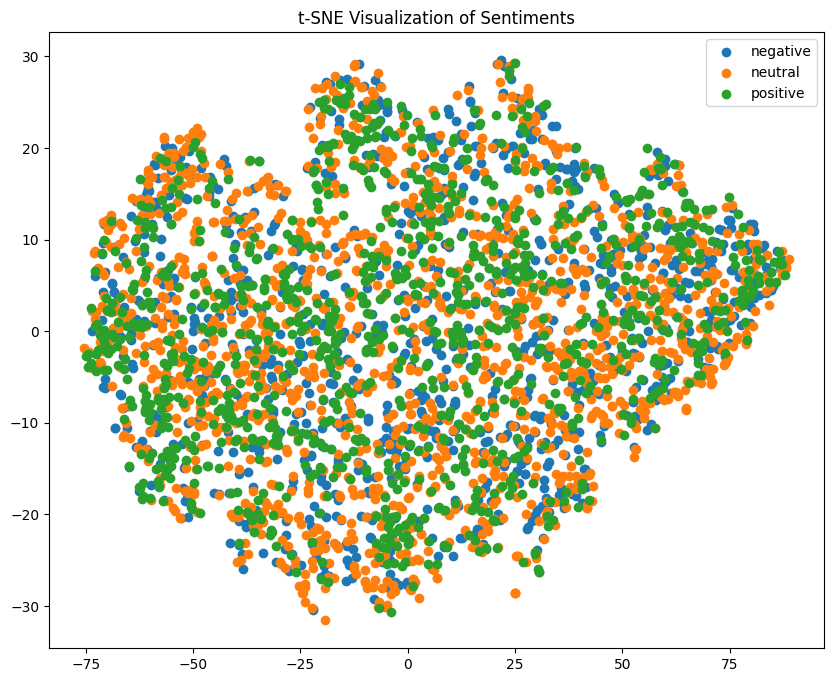

In [54]:
# prompt: use tsne to plot different sentiments based on the embeddings test_dataset.embeddings.numpy() and labels .labels()

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming test_dataset.embeddings.numpy() and test_dataset.labels() are defined

embeddings = test_dataset_embed.embeddings.numpy()
labels = test_dataset_embed.labels.numpy()  # Assuming labels() is a method

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=sentiment_reverse_mapping[label])

plt.legend()
plt.title('t-SNE Visualization of Sentiments')
plt.show()

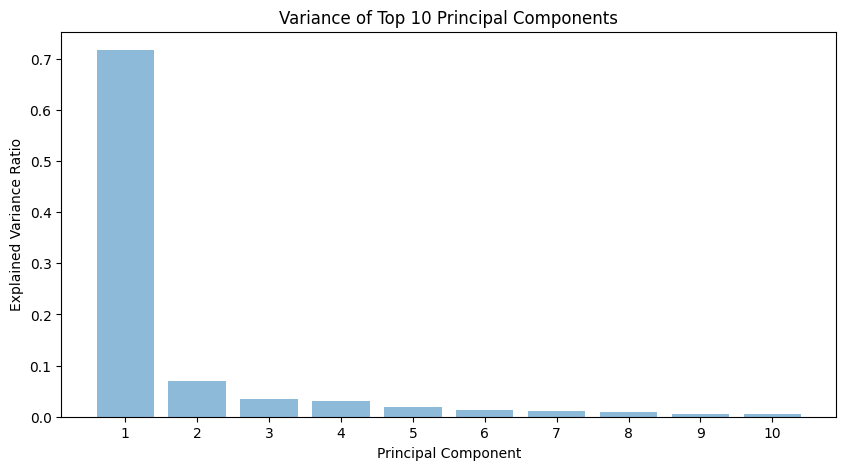

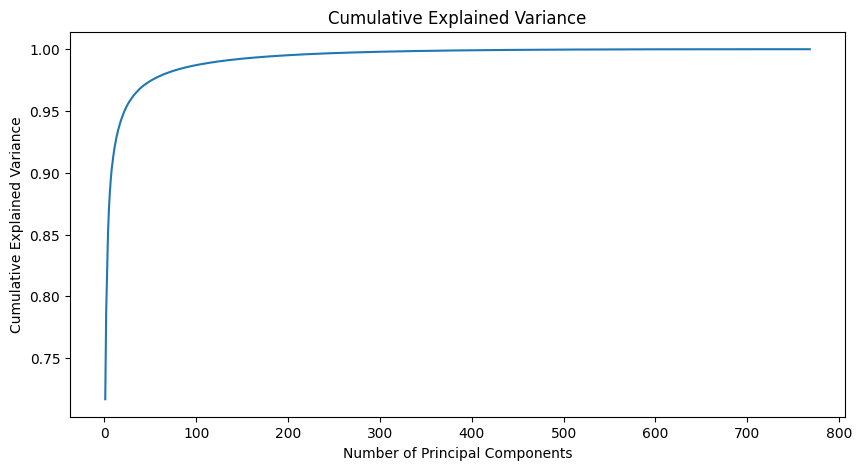

In [55]:
# prompt: PCA decomposition , bar plot variance of top 10 components and cumulative explained variance

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'embeddings' is your data (replace with your actual data)
embeddings = test_dataset_embed.embeddings.numpy()

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(embeddings)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot variance of top 10 components
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), explained_variance_ratio[:10], alpha=0.5, align='center')
plt.xticks(range(1, 11))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance of Top 10 Principal Components')
plt.show()

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

In [56]:
# Function to test the ML models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.patches as patches

# def test_ml_model(model, test_dataset=test_dataset_embed, validation_dataset=val_dataset_embed):
#     # Make predictions
#     test_label_pred = model.predict(test_dataset.embeddings.numpy())
#     validation_label_pred = model.predict(validation_dataset.embeddings.numpy())

#     # Compute confusion matrices
#     cm_test = confusion_matrix(test_dataset.labels.numpy(), test_label_pred)
#     cm_validation = confusion_matrix(validation_dataset.labels.numpy(), validation_label_pred)

#     # Set up the subplots
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

#     # Plot test confusion matrix
#     sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
#                 xticklabels=list(sentiment_reverse_mapping.values()),
#                 yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
#     axes[0].set_title("Test Confusion Matrix")
#     axes[0].set_xlabel("Predicted Labels")
#     axes[0].set_ylabel("True Labels")

#     # Highlight the diagonal (correct predictions) for test set
#     for i in range(cm_test.shape[0]):
#         axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

#     # Plot validation confusion matrix
#     sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
#                 xticklabels=list(sentiment_reverse_mapping.values()),
#                 yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
#     axes[1].set_title("Validation Confusion Matrix")
#     axes[1].set_xlabel("Predicted Labels")
#     axes[1].set_ylabel("True Labels")

#     # Highlight the diagonal (correct predictions) for validation set
#     for i in range(cm_validation.shape[0]):
#         axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

#     # Print classification reports for both test and validation
#     print("Test Classification Report:")
#     print(f"Overall Score {(model.score(test_dataset.embeddings.numpy(),test_dataset.labels.numpy())*100):.2f}%")
#     print(classification_report(test_dataset.labels.numpy(), test_label_pred))

#     print("Validation Classification Report:")
#     print(f"Overall Score {(model.score(validation_dataset.embeddings.numpy(),validation_dataset.labels.numpy())*100):.2f}%")
#     print(classification_report(validation_dataset.labels.numpy(), validation_label_pred))

def test_ml_model(model, model_name, test_dataset=test_dataset_embed, validation_dataset=val_dataset_embed):
    # Make predictions
    test_label_pred = model.predict(test_dataset.embeddings.numpy())
    validation_label_pred = model.predict(validation_dataset.embeddings.numpy())

    # Compute confusion matrices
    cm_test = confusion_matrix(test_dataset.labels.numpy(), test_label_pred)
    cm_validation = confusion_matrix(validation_dataset.labels.numpy(), validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Get classification report as dictionary
    test_report = classification_report(test_dataset.labels.numpy(), test_label_pred, output_dict=True)
    validation_report = classification_report(validation_dataset.labels.numpy(), validation_label_pred, output_dict=True)

    # Print classification reports
    print("Test Classification Report:")
    print(f"Overall Score {(model.score(test_dataset.embeddings.numpy(), test_dataset.labels.numpy()) * 100):.2f}%")
    print(classification_report(test_dataset.labels.numpy(), test_label_pred))

    print("Validation Classification Report:")
    print(f"Overall Score {(model.score(validation_dataset.embeddings.numpy(), validation_dataset.labels.numpy()) * 100):.2f}%")
    print(classification_report(validation_dataset.labels.numpy(), validation_label_pred))

    # Extract key metrics
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }

    return metrics

In [57]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

DecisionTreeClassifier(random_state=42)

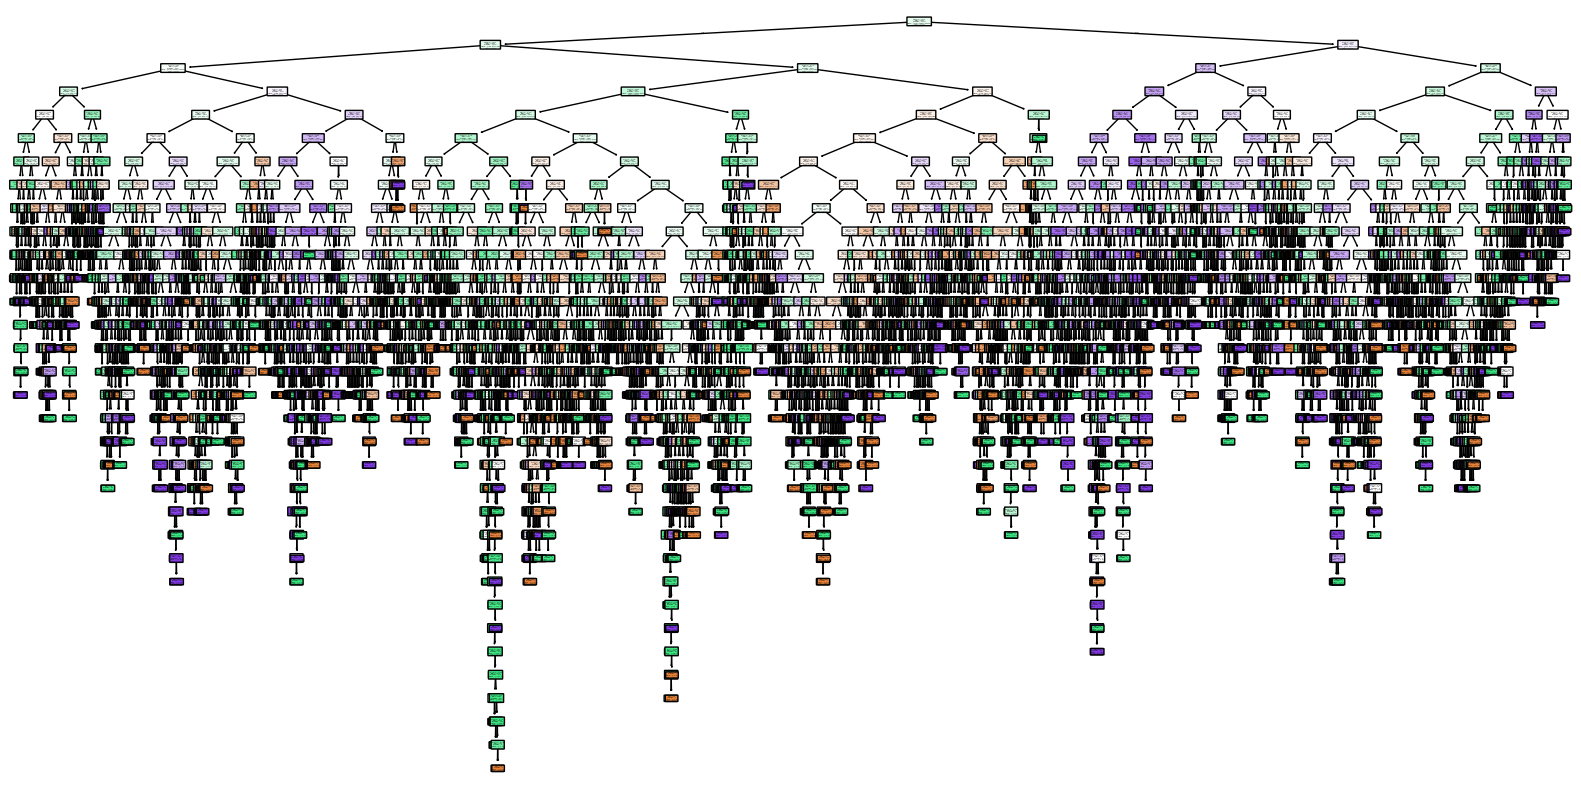

In [58]:


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=None, class_names=['negative', 'neutral', 'positive'], rounded=True)
plt.show()

In [60]:
results = []

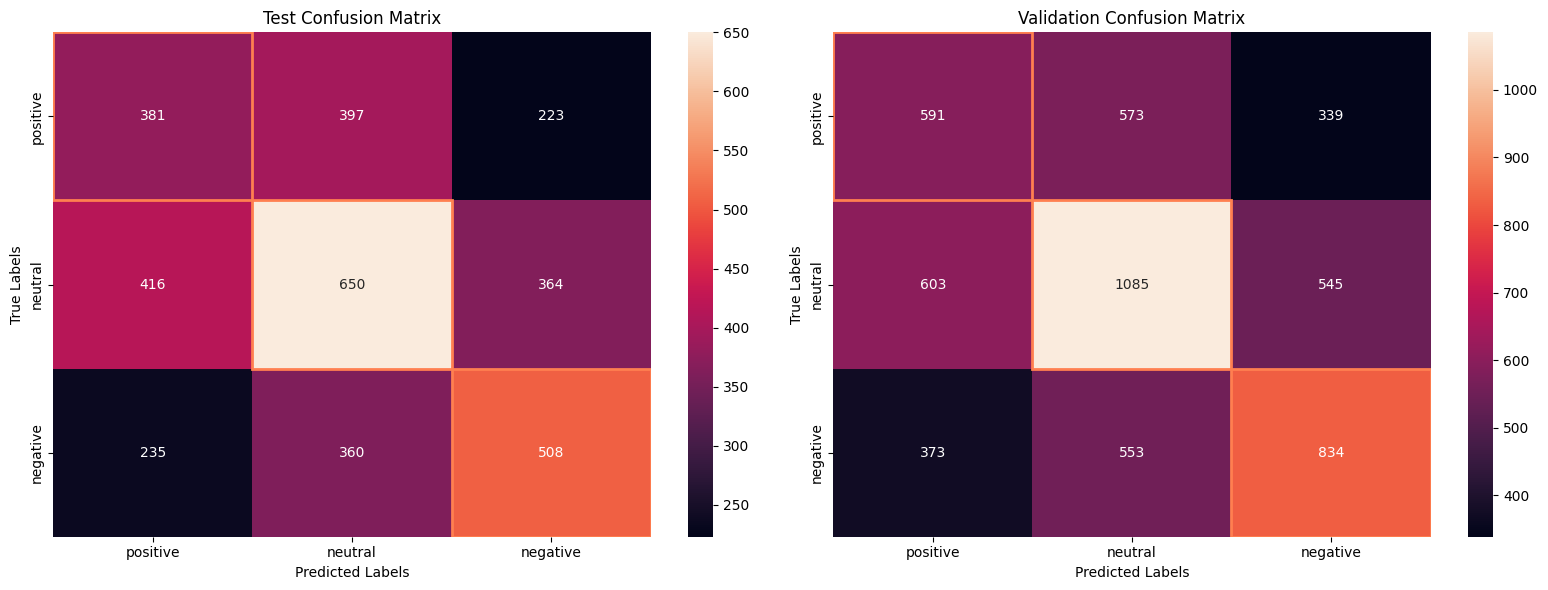

Test Classification Report:
Overall Score 43.55%
              precision    recall  f1-score   support

           0       0.37      0.38      0.37      1001
           1       0.46      0.45      0.46      1430
           2       0.46      0.46      0.46      1103

    accuracy                           0.44      3534
   macro avg       0.43      0.43      0.43      3534
weighted avg       0.44      0.44      0.44      3534

Validation Classification Report:
Overall Score 45.67%
              precision    recall  f1-score   support

           0       0.38      0.39      0.39      1503
           1       0.49      0.49      0.49      2233
           2       0.49      0.47      0.48      1760

    accuracy                           0.46      5496
   macro avg       0.45      0.45      0.45      5496
weighted avg       0.46      0.46      0.46      5496



In [61]:
results.append(test_ml_model(dt,"Decision Tree"))

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=42,verbose = True)
rf.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   44.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomForestClassifier(random_state=42, verbose=True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


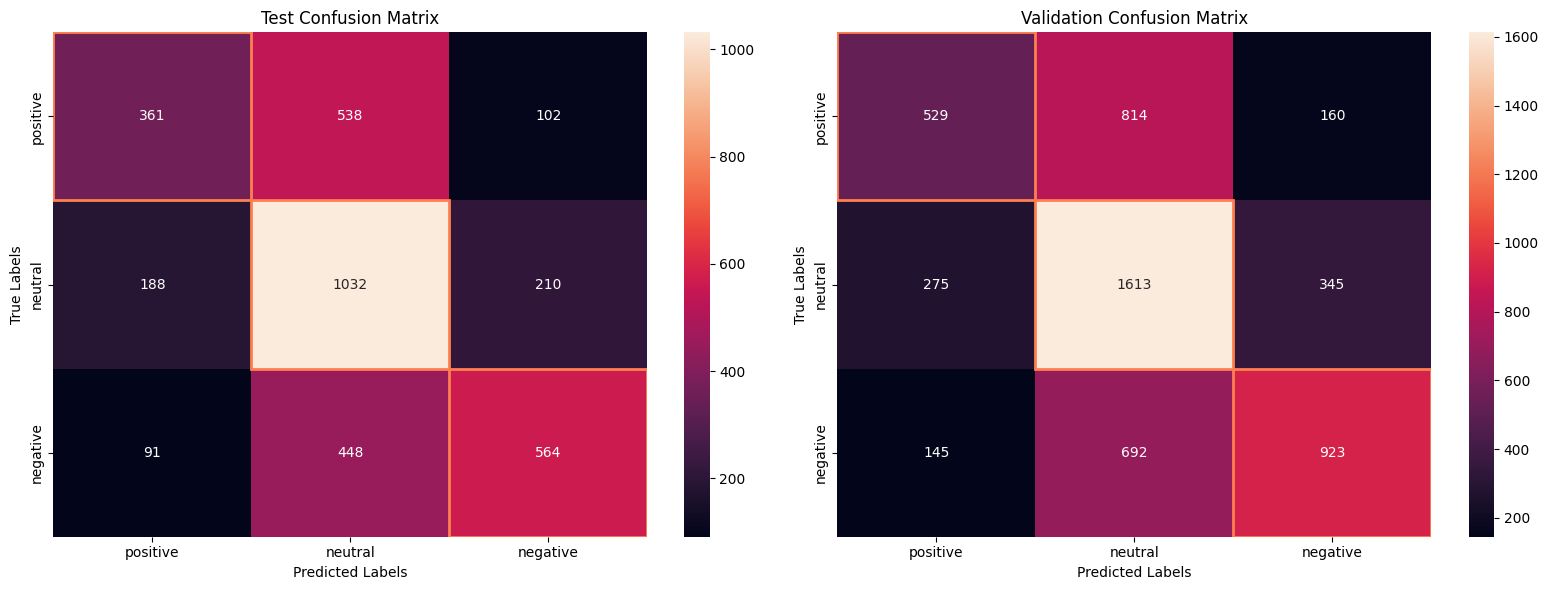

Test Classification Report:
Overall Score 55.38%
              precision    recall  f1-score   support

           0       0.56      0.36      0.44      1001
           1       0.51      0.72      0.60      1430
           2       0.64      0.51      0.57      1103

    accuracy                           0.55      3534
   macro avg       0.57      0.53      0.54      3534
weighted avg       0.57      0.55      0.54      3534

Validation Classification Report:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Overall Score 55.77%
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1503
           1       0.52      0.72      0.60      2233
           2       0.65      0.52      0.58      1760

    accuracy                           0.56      5496
   macro avg       0.57      0.53      0.54      5496
weighted avg       0.57      0.56      0.55      5496



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [63]:
results.append(test_ml_model(rf,"Random Forest"))

In [64]:
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.001,0.01,0.1,1,2,3]}

LR = LogisticRegression(max_iter=1000)
LR.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())
# grid_search = GridSearchCV(estimator=LR, param_grid=param_grid)
# grid_search.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())
# LR= grid_search.best_estimator_
# print(grid_search.best_params_["C"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

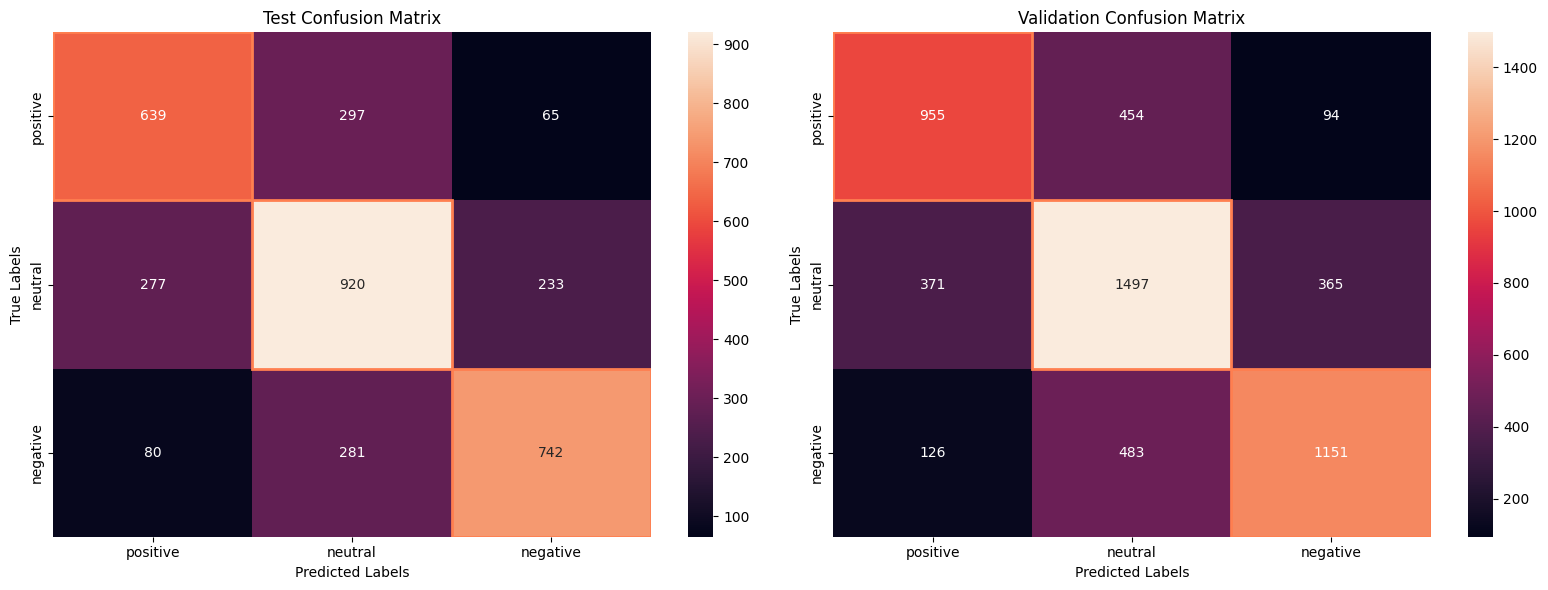

Test Classification Report:
Overall Score 65.11%
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1001
           1       0.61      0.64      0.63      1430
           2       0.71      0.67      0.69      1103

    accuracy                           0.65      3534
   macro avg       0.66      0.65      0.65      3534
weighted avg       0.65      0.65      0.65      3534

Validation Classification Report:
Overall Score 65.56%
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1503
           1       0.62      0.67      0.64      2233
           2       0.71      0.65      0.68      1760

    accuracy                           0.66      5496
   macro avg       0.66      0.65      0.66      5496
weighted avg       0.66      0.66      0.66      5496



In [65]:
results.append(test_ml_model(LR,"Logistic Regression"))

In [66]:
df_results = pd.DataFrame(results)

In [67]:
df_results

,model_name,test_accuracy,test_precision,test_recall,test_f1-score,validation_accuracy,validation_precision,validation_recall,validation_f1-score
0,Decision Tree,0.435484,0.436302,0.435484,0.435854,0.456696,0.457978,0.456696,0.457264
1,Random Forest,0.553763,0.567650,0.553763,0.544742,0.557678,0.569543,0.557678,0.548329
2,Logistic Regression,0.651104,0.652913,0.651104,0.651683,0.655568,0.658689,0.655568,0.656157


In [68]:

import seaborn as sns


def plot_model_metrics(df_results):
    sns.set_theme(style="whitegrid")  # Use a clean style

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

    metrics = ["accuracy", "precision", "recall", "f1-score"]
    titles = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = sns.color_palette("deep", 4)  # Seaborn color palette

    for i, metric in enumerate(metrics):
        # Test Metrics
        sns.barplot(x="model_name", y=f"test_{metric}", data=df_results, ax=axes[0, i], color=colors[i])
        axes[0, i].set_title(f"Test {titles[i]}", fontsize=14)
        axes[0, i].set_ylim(0, 1)
        axes[0, i].set_ylabel("Score")
        axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)

        # Validation Metrics
        sns.barplot(x="model_name", y=f"validation_{metric}", data=df_results, ax=axes[1, i], color=colors[i])
        axes[1, i].set_title(f"Validation {titles[i]}", fontsize=14)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].set_ylabel("Score")
        axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)

    fig.suptitle("Model Performance Comparison", fontsize=18, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for title
    plt.show()
    best_model = df_results.loc[df_results["test_accuracy"].idxmax()]
    print(f"The best model is {best_model['model_name']} with a test accuracy of {best_model['test_accuracy'] * 100:.2f}%")




/tmp/ipython-input-4054688041.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)
/tmp/ipython-input-4054688041.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)
/tmp/ipython-input-4054688041.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)
/tmp/ipython-input-4054688041.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)
/tmp/ipython-i

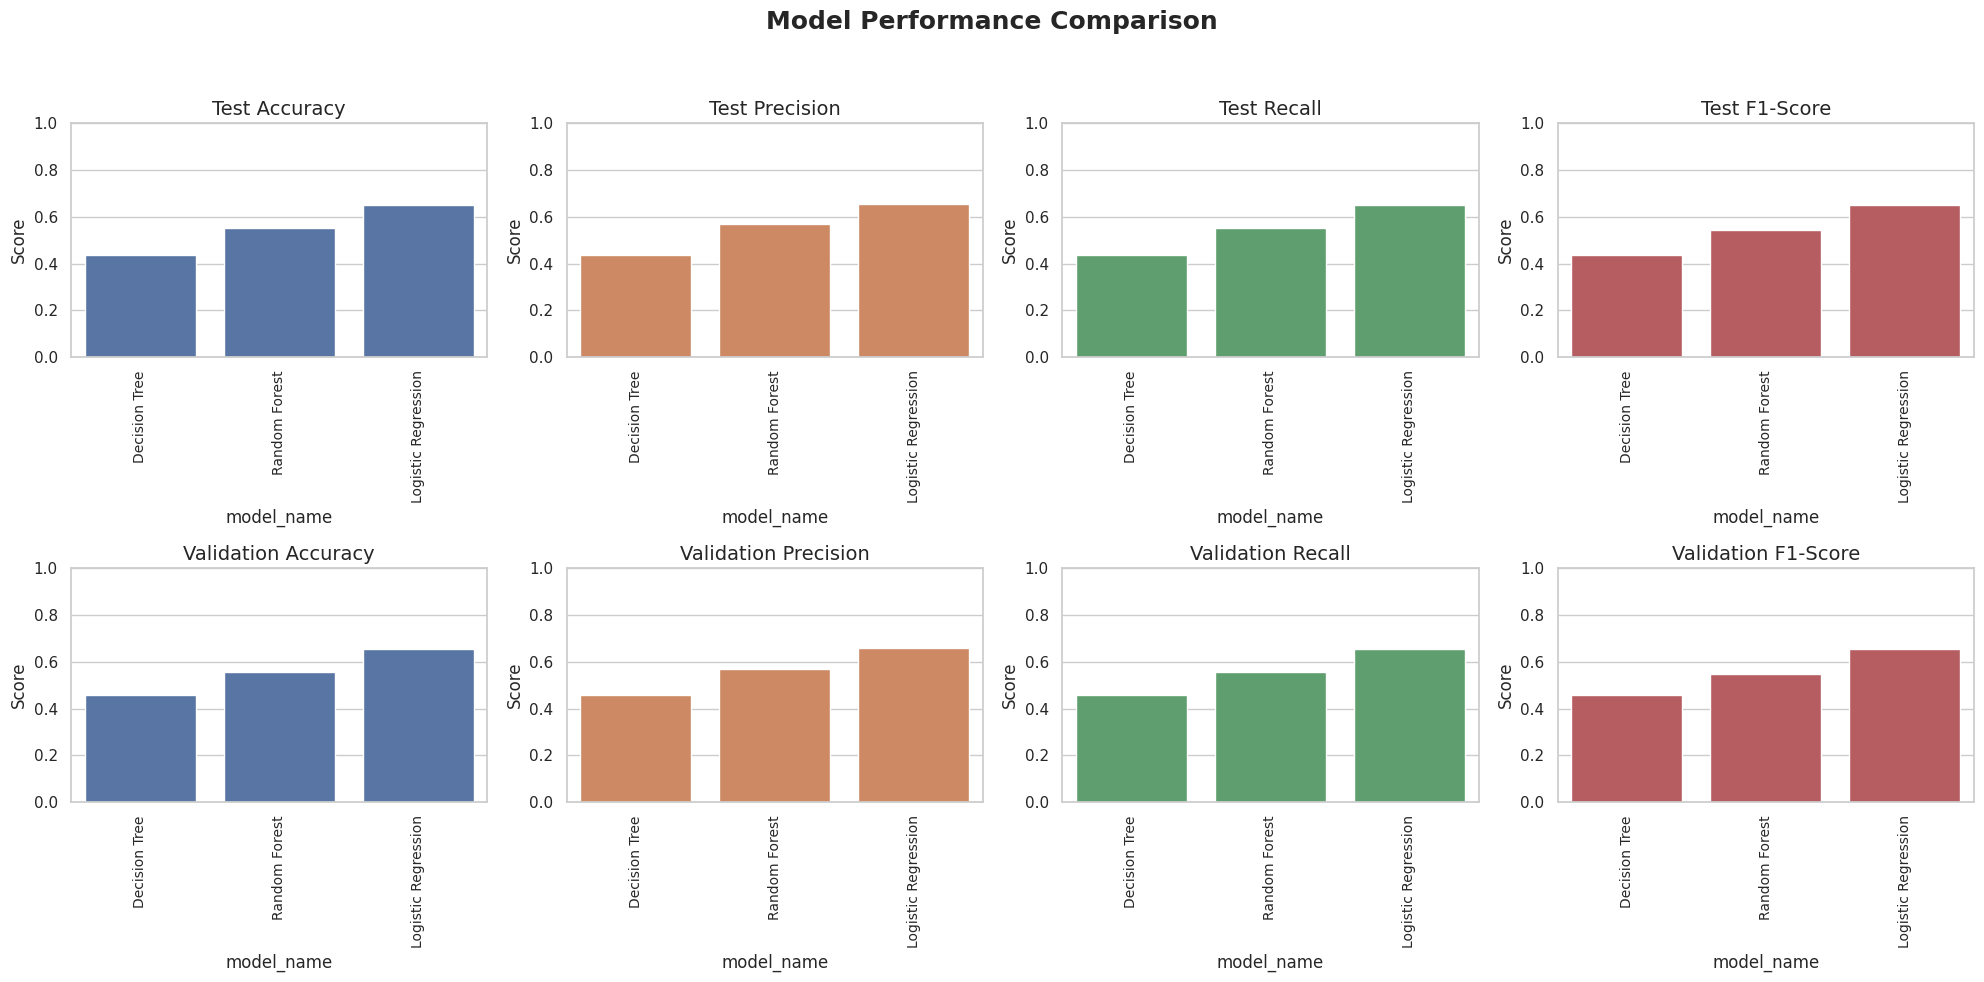

The best model is Logistic Regression with a test accuracy of 65.11%


In [69]:
plot_model_metrics(df_results)

In [70]:

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
             nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(128, output_dim)
        )
        # Weight Initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight,nonlinearity='relu')  # Xavier initialization for linear layers
                nn.init.zeros_(layer.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.layers(x)



In [71]:
import torch
from torch import nn
from torch.optim import Adadelta,Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [72]:
# Hyperparameters
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 20

In [ ]:


# Example: embedding_dim = 768 (BERT base)
embedding_dim = train_dataset_embed.embeddings.shape[1]

# Instantiate the model, optimizer, and learning rate scheduler
model = MLP(embedding_dim, NUM_CLASSES).to(device) # Example hidden_dim
# model = EmbeddingClassifier(embedding_dim, NUM_CLASSES).to(device)
# optimizer = Adadelta(model.parameters())
optimizer = Adam(model.parameters(),lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


# Training loop (example)
num_epochs = EPOCHS
criterion = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
best_val_loss = float('inf')
epochs_since_improvement = 0
best_epoch = 0
bad_patience=4
patience=5
checkpoint_folder = 'checkpoints'
os.makedirs(checkpoint_folder, exist_ok=True)
torch.save(model.state_dict(), os.path.join(checkpoint_folder, 'initial_model.pth'))

In [74]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    for data, target in tqdm(trainloader_embed, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    epoch_train_loss = running_loss / len(trainloader_embed.dataset)
    train_loss_history.append(epoch_train_loss)
    epoch_train_accuracy = correct_train / total_train
    train_accuracy_history.append(epoch_train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
      for data, target in tqdm(valloader_embed, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
          data, target = data.to(device), target.to(device)
          output = model(data)
          val_running_loss += criterion(output, target).item()
          _, predicted = torch.max(output, 1)
          total_val += target.size(0)
          correct_val += (predicted == target).sum().item()

    val_running_loss /= len(valloader_embed)
    val_loss_history.append(val_running_loss)
    scheduler.step(val_running_loss) # Update learning rate based on validation loss
    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        epochs_since_improvement = 0
        best_epoch = epoch + 1
        # Save the model checkpoint at the best epoch
        torch.save(model.state_dict(), os.path.join(checkpoint_folder, f'best_model_epoch_{epoch+1}.pth'))
        print("Validation loss improved. Saving model checkpoint.")
    else:
        epochs_since_improvement += 1
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered. No improvement in {patience} epochs.")
            break

        # If validation loss worsened, rollback to the best model
        if val_running_loss > best_val_loss and epochs_since_improvement >=bad_patience:
            print("Validation loss increased. Rolling back to best model.")
            model.load_state_dict(torch.load(os.path.join(checkpoint_folder, f'best_model_epoch_{best_epoch}.pth')))
            optimizer.zero_grad()
            epochs_since_improvement = 0
            scheduler.step(val_running_loss)
    print(f"current lr : {optimizer.param_groups[0]['lr']}")
    epoch_val_accuracy = correct_val / total_val
    val_accuracy_history.append(epoch_val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_running_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

Epoch 1/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 176.28it/s]


Epoch [1/20], Training Loss: 0.0197, Training Accuracy: 0.3750


Epoch 1/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 354.14it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [1/20], Validation Loss: 1.0415, Validation Accuracy: 0.4751


Epoch 2/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 278.54it/s]


Epoch [2/20], Training Loss: 0.0175, Training Accuracy: 0.4509


Epoch 2/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 385.32it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [2/20], Validation Loss: 0.9797, Validation Accuracy: 0.5244


Epoch 3/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 281.02it/s]


Epoch [3/20], Training Loss: 0.0165, Training Accuracy: 0.4825


Epoch 3/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 312.35it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [3/20], Validation Loss: 0.9403, Validation Accuracy: 0.5540


Epoch 4/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 280.27it/s]


Epoch [4/20], Training Loss: 0.0160, Training Accuracy: 0.5038


Epoch 4/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 379.10it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [4/20], Validation Loss: 0.9268, Validation Accuracy: 0.5582


Epoch 5/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 280.70it/s]


Epoch [5/20], Training Loss: 0.0156, Training Accuracy: 0.5174


Epoch 5/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 387.34it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [5/20], Validation Loss: 0.9075, Validation Accuracy: 0.5675


Epoch 6/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 279.72it/s]


Epoch [6/20], Training Loss: 0.0152, Training Accuracy: 0.5334


Epoch 6/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 372.01it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [6/20], Validation Loss: 0.8927, Validation Accuracy: 0.5733


Epoch 7/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 257.43it/s]


Epoch [7/20], Training Loss: 0.0149, Training Accuracy: 0.5438


Epoch 7/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 271.53it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [7/20], Validation Loss: 0.8849, Validation Accuracy: 0.5841


Epoch 8/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 218.41it/s]


Epoch [8/20], Training Loss: 0.0147, Training Accuracy: 0.5545


Epoch 8/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 373.39it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [8/20], Validation Loss: 0.8774, Validation Accuracy: 0.5857


Epoch 9/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 279.58it/s]


Epoch [9/20], Training Loss: 0.0145, Training Accuracy: 0.5581


Epoch 9/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 303.85it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [9/20], Validation Loss: 0.8698, Validation Accuracy: 0.5915


Epoch 10/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 279.68it/s]


Epoch [10/20], Training Loss: 0.0143, Training Accuracy: 0.5705


Epoch 10/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 362.43it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [10/20], Validation Loss: 0.8610, Validation Accuracy: 0.5915


Epoch 11/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 257.07it/s]


Epoch [11/20], Training Loss: 0.0142, Training Accuracy: 0.5706


Epoch 11/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 336.08it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [11/20], Validation Loss: 0.8516, Validation Accuracy: 0.5953


Epoch 12/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 279.25it/s]


Epoch [12/20], Training Loss: 0.0140, Training Accuracy: 0.5765


Epoch 12/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 362.50it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [12/20], Validation Loss: 0.8500, Validation Accuracy: 0.6003


Epoch 13/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 282.69it/s]


Epoch [13/20], Training Loss: 0.0139, Training Accuracy: 0.5804


Epoch 13/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 385.94it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [13/20], Validation Loss: 0.8476, Validation Accuracy: 0.6041


Epoch 14/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 283.06it/s]


Epoch [14/20], Training Loss: 0.0139, Training Accuracy: 0.5842


Epoch 14/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 378.99it/s]


current lr : 2e-05
Epoch [14/20], Validation Loss: 0.8478, Validation Accuracy: 0.6006


Epoch 15/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 284.98it/s]


Epoch [15/20], Training Loss: 0.0137, Training Accuracy: 0.5868


Epoch 15/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 391.70it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [15/20], Validation Loss: 0.8420, Validation Accuracy: 0.6063


Epoch 16/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 242.31it/s]


Epoch [16/20], Training Loss: 0.0136, Training Accuracy: 0.5937


Epoch 16/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 259.63it/s]


current lr : 2e-05
Epoch [16/20], Validation Loss: 0.8461, Validation Accuracy: 0.6024


Epoch 17/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 240.41it/s]


Epoch [17/20], Training Loss: 0.0136, Training Accuracy: 0.5958


Epoch 17/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 393.56it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [17/20], Validation Loss: 0.8329, Validation Accuracy: 0.6094


Epoch 18/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 280.94it/s]


Epoch [18/20], Training Loss: 0.0134, Training Accuracy: 0.6036


Epoch 18/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 359.81it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [18/20], Validation Loss: 0.8286, Validation Accuracy: 0.6141


Epoch 19/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 279.93it/s]


Epoch [19/20], Training Loss: 0.0133, Training Accuracy: 0.6036


Epoch 19/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 384.81it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [19/20], Validation Loss: 0.8276, Validation Accuracy: 0.6152


Epoch 20/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 282.33it/s]


Epoch [20/20], Training Loss: 0.0132, Training Accuracy: 0.6119


Epoch 20/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 383.98it/s]

current lr : 2e-05
Epoch [20/20], Validation Loss: 0.8327, Validation Accuracy: 0.6124


In [75]:

import matplotlib.pyplot as plt

def plot_metrics(train_loss_history=train_loss_history, val_loss_history=val_loss_history, train_accuracy_history=train_accuracy_history, val_accuracy_history=val_accuracy_history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training and validation losses
    axes[0].plot(train_loss_history,'o-' ,label='Training Loss')
    axes[0].plot(val_loss_history,'o-', label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    plt.grid(True)
    axes[0].legend()

    # Plot training and validation accuracies
    axes[1].plot(train_accuracy_history,'o-', label='Training Accuracy')
    axes[1].plot(val_accuracy_history, 'o-',label='Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

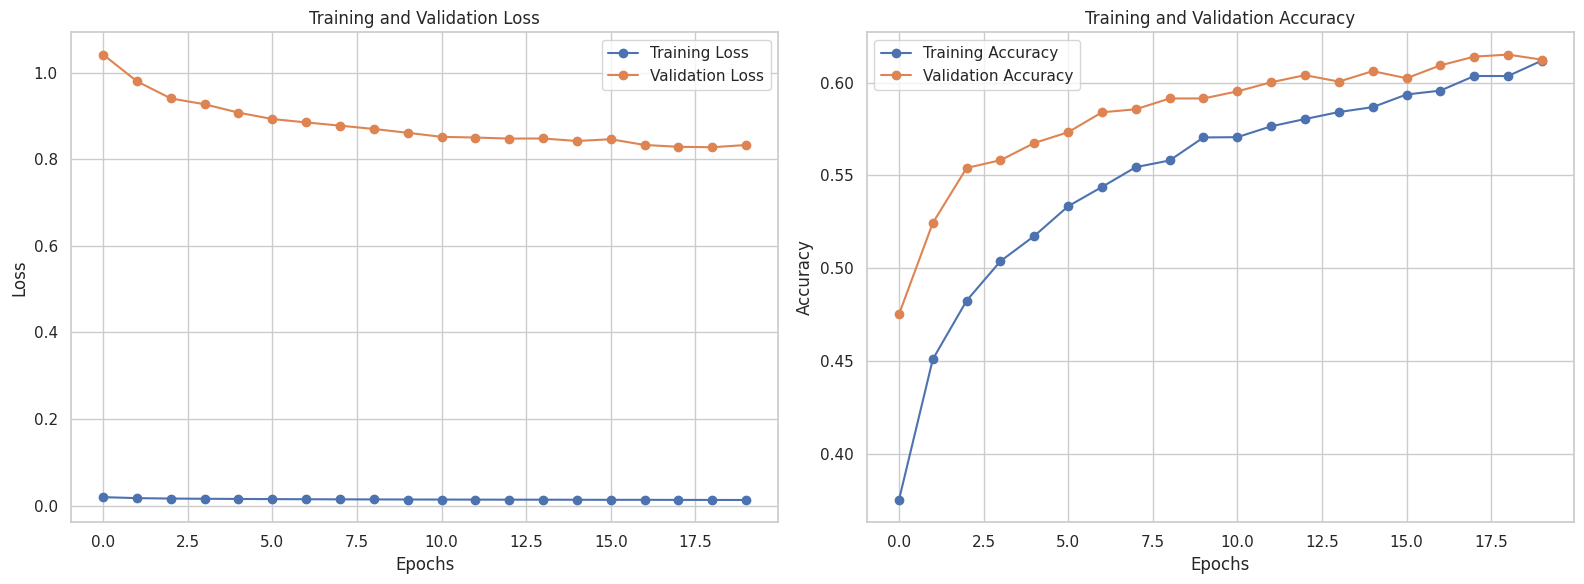

In [76]:
plot_metrics(train_loss_history,val_loss_history,train_accuracy_history,val_accuracy_history)

In [77]:
def test_dl_model(model,model_name="MLP", test_loader=testloader_embed, validation_loader=valloader_embed, device=device):
    """
    Evaluates a deep learning model and visualizes the confusion matrices.

    Args:
        model (nn.Module): The deep learning model.
        test_loader (DataLoader): DataLoader for the test dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        sentiment_reverse_mapping (dict): Mapping from numerical labels to sentiment labels.
    """

    model.eval()  # Set the model to evaluation mode

    # Get predictions for test and validation sets
    test_label_pred, test_label_true = get_predictions(model, test_loader, device)
    validation_label_pred, validation_label_true = get_predictions(model, validation_loader, device)

    # Compute confusion matrices
    cm_test = confusion_matrix(test_label_true, test_label_pred)
    cm_validation = confusion_matrix(validation_label_true, validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Show the plot
    plt.tight_layout()
    plt.show()
    test_report = classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    # Print classification reports for both test and validation
    print("Test Classification Report:")
    print(f"Overall Score {(np.trace(cm_test) / np.sum(cm_test))*100:.2f}%")
    print(classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    validation_report = classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    print("Validation Classification Report:")
    print(f"Overall Score {(np.trace(cm_validation) / np.sum(cm_validation))*100:.2f}%")
    print(classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }
    return metrics

def get_predictions(model, data_loader, device):
    """
    Gets predictions from a deep learning model for a given data loader.

    Args:
        model (nn.Module): The deep learning model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        tuple: A tuple containing the predicted labels and true labels.
    """

    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            inputs, labels= batch
            inputs,labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

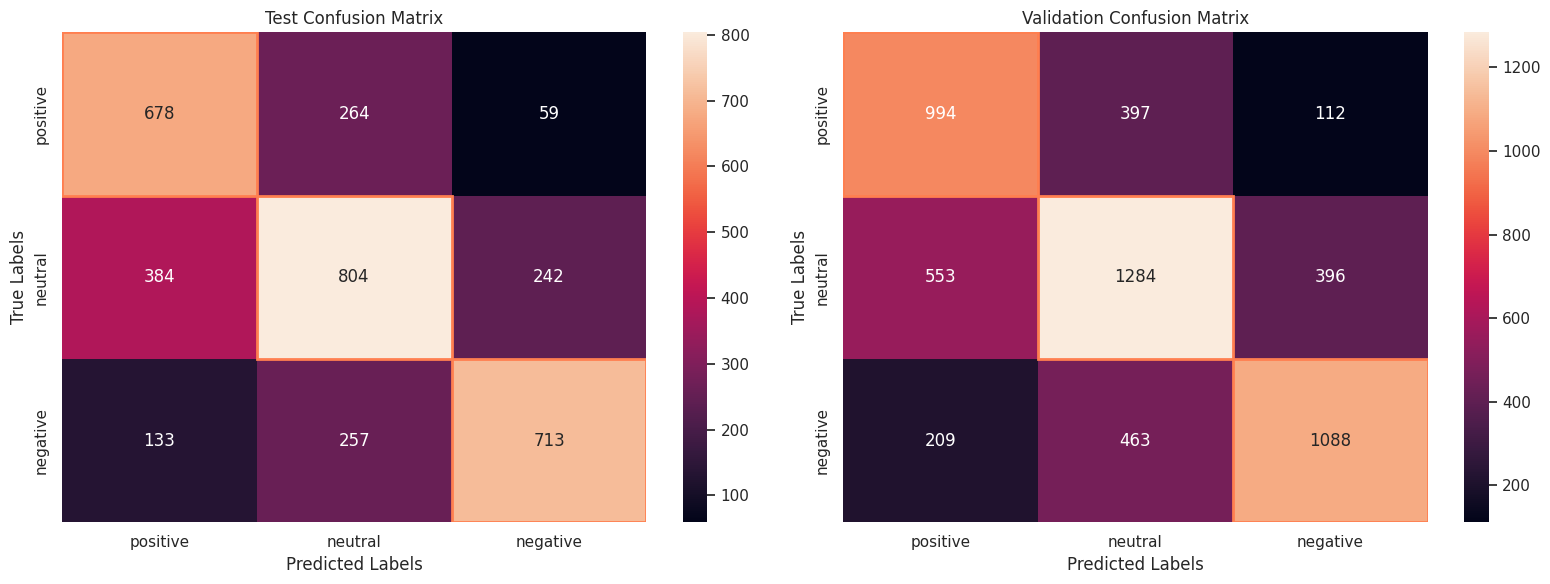

Test Classification Report:
Overall Score 62.11%
              precision    recall  f1-score   support

    positive       0.57      0.68      0.62      1001
     neutral       0.61      0.56      0.58      1430
    negative       0.70      0.65      0.67      1103

    accuracy                           0.62      3534
   macro avg       0.63      0.63      0.62      3534
weighted avg       0.63      0.62      0.62      3534

Validation Classification Report:
Overall Score 61.24%
              precision    recall  f1-score   support

    positive       0.57      0.66      0.61      1503
     neutral       0.60      0.58      0.59      2233
    negative       0.68      0.62      0.65      1760

    accuracy                           0.61      5496
   macro avg       0.62      0.62      0.62      5496
weighted avg       0.62      0.61      0.61      5496



In [78]:
results.append(test_dl_model(model))

In [79]:
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch

# Load the pre-trained model for sequence classification
model_llm_before_finetune = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 classes: positive, neutral, negative
model_llm_before_finetune.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [80]:

model_llm = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 classes: positive, neutral, negative

# Set the model to the correct device
model_llm.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [81]:

def get_bert_predictions(model, data_loader, device,custom=False):
    """
    Gets predictions from a BertForSequenceClassification model.

    Args:
        model (BertForSequenceClassification): The BERT classifier model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        tuple: A tuple containing the predicted labels and true labels.
    """

    all_predictions = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU if available
            labels = labels.to(device)
            if custom:
              logits = model(**inputs)
            else:
              logits = model(**inputs).logits


            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


In [82]:
def test_llm_model(model,model_name, test_loader=testloader_tokenized, validation_loader=valloader_tokenized, device=device,custom=False):
    """
    Evaluates a BertForSequenceClassification model and visualizes confusion matrices.

    Args:
        model (BertForSequenceClassification): The BERT classifier model.
        test_loader (DataLoader): DataLoader for the test dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        sentiment_reverse_mapping (dict): Mapping from numerical labels to sentiment labels.
    """

    # Get predictions for test and validation sets

    test_label_pred, test_label_true = get_bert_predictions(model, test_loader, device,custom=custom)
    validation_label_pred, validation_label_true = get_bert_predictions(model, validation_loader, device,custom=custom)

    # Compute confusion matrices
    cm_test = confusion_matrix(test_label_true, test_label_pred)
    cm_validation = confusion_matrix(validation_label_true, validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    plt.tight_layout()
    plt.show()
    test_report = classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    # Print classification reports
    print("Test Classification Report:")
    print(f"Overall Score {(np.trace(cm_test) / np.sum(cm_test)) * 100:.2f}%")
    print(classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    validation_report = classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    print("Validation Classification Report:")
    print(f"Overall Score {(np.trace(cm_validation) / np.sum(cm_validation)) * 100:.2f}%")
    print(classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }
    return metrics

LLM before tuning


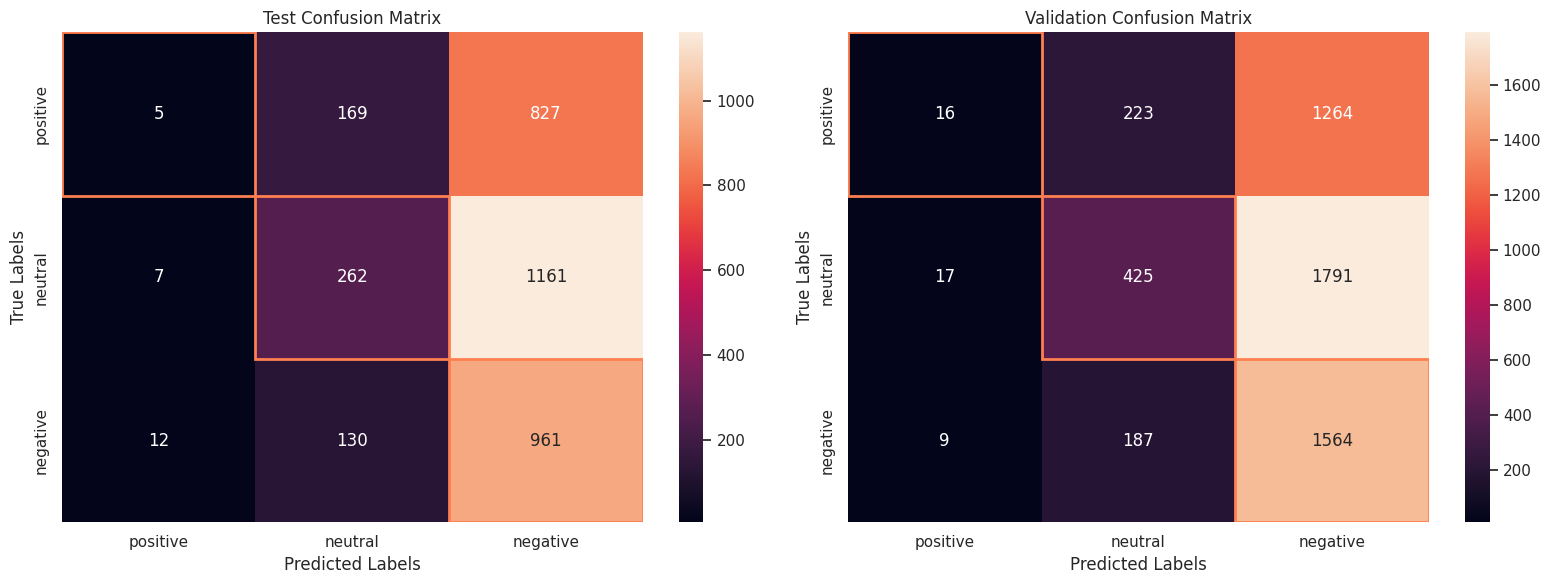

Test Classification Report:
Overall Score 34.75%
              precision    recall  f1-score   support

    positive       0.21      0.00      0.01      1001
     neutral       0.47      0.18      0.26      1430
    negative       0.33      0.87      0.47      1103

    accuracy                           0.35      3534
   macro avg       0.33      0.35      0.25      3534
weighted avg       0.35      0.35      0.26      3534

Validation Classification Report:
Overall Score 36.48%
              precision    recall  f1-score   support

    positive       0.38      0.01      0.02      1503
     neutral       0.51      0.19      0.28      2233
    negative       0.34      0.89      0.49      1760

    accuracy                           0.36      5496
   macro avg       0.41      0.36      0.26      5496
weighted avg       0.42      0.36      0.28      5496



In [83]:
print("LLM before tuning")
results.append(test_llm_model(model_llm_before_finetune,"Not finetuned LLM"))

In [84]:
optimizer = Adam(model_llm.parameters(), lr=2e-5)  # Fine-tuning BERT typically uses a low LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

criterion = nn.CrossEntropyLoss()

# Training settings
num_epochs = 10
patience = 5
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

In [85]:
def train_model(model, train_loader=train_loader_tokenized, val_loader=valloader_tokenized, device=device, num_epochs=10, patience=patience, lr=0.001, bad_patience=3, checkpoint_folder='checkpoints',custom=False):
    os.makedirs(checkpoint_folder, exist_ok=True)
    best_val_loss = float('inf')
    epochs_since_improvement = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()
            if custom:
              outputs= model(**inputs)
            else:
              outputs = model(**inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)
        epoch_train_accuracy = correct_train / total_train
        train_accuracy_history.append(epoch_train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = batch
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)
                if custom:
                  outputs = model(**inputs)
                else:
                  outputs = model(**inputs).logits
                val_running_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_running_loss /= len(val_loader)
        val_loss_history.append(val_running_loss)
        scheduler.step(val_running_loss)

        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            epochs_since_improvement = 0
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(checkpoint_folder, f'best_model_epoch_{epoch+1}.pth'))
            print("Validation loss improved. Saving model checkpoint.")
        else:
            epochs_since_improvement += 1
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered. No improvement in {patience} epochs.")
                break

            if val_running_loss > best_val_loss and epochs_since_improvement >= bad_patience:
                print("Validation loss increased. Rolling back to best model.")
                model.load_state_dict(torch.load(os.path.join(checkpoint_folder, f'best_model_epoch_{best_epoch}.pth')))
                optimizer.zero_grad()
                epochs_since_improvement = 0

        epoch_val_accuracy = correct_val / total_val
        val_accuracy_history.append(epoch_val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_running_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']}")

In [86]:
train_model(model_llm)

Epoch 1/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.03it/s]


Epoch [1/10], Training Loss: 0.6717, Training Accuracy: 0.7067


Epoch 1/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Validation loss improved. Saving model checkpoint.
Epoch [1/10], Validation Loss: 0.5435, Validation Accuracy: 0.7822
Current LR: 2e-05


Epoch 2/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.04it/s]


Epoch [2/10], Training Loss: 0.4941, Training Accuracy: 0.8043


Epoch 2/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Epoch [2/10], Validation Loss: 0.5476, Validation Accuracy: 0.7787
Current LR: 2e-05


Epoch 3/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.04it/s]


Epoch [3/10], Training Loss: 0.3840, Training Accuracy: 0.8533


Epoch 3/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Epoch [3/10], Validation Loss: 0.6044, Validation Accuracy: 0.7724
Current LR: 2e-05


Epoch 4/10 - Training: 100%|██████████| 344/344 [05:31<00:00,  1.04it/s]


Epoch [4/10], Training Loss: 0.2760, Training Accuracy: 0.9006


Epoch 4/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s]


Validation loss increased. Rolling back to best model.
Epoch [4/10], Validation Loss: 0.6853, Validation Accuracy: 0.7695
Current LR: 2e-05


Epoch 5/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.04it/s]


Epoch [5/10], Training Loss: 0.4888, Training Accuracy: 0.8065


Epoch 5/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Epoch [5/10], Validation Loss: 0.5522, Validation Accuracy: 0.7735
Current LR: 2.0000000000000003e-06


Epoch 6/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.04it/s]


Epoch [6/10], Training Loss: 0.3818, Training Accuracy: 0.8533


Epoch 6/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s]


Epoch [6/10], Validation Loss: 0.5718, Validation Accuracy: 0.7795
Current LR: 2.0000000000000003e-06


Epoch 7/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.03it/s]


Epoch [7/10], Training Loss: 0.3629, Training Accuracy: 0.8651


Epoch 7/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Validation loss increased. Rolling back to best model.
Epoch [7/10], Validation Loss: 0.5809, Validation Accuracy: 0.7826
Current LR: 2.0000000000000003e-06


Epoch 8/10 - Training: 100%|██████████| 344/344 [05:31<00:00,  1.04it/s]


Epoch [8/10], Training Loss: 0.4775, Training Accuracy: 0.8143


Epoch 8/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Epoch [8/10], Validation Loss: 0.5552, Validation Accuracy: 0.7807
Current LR: 2.0000000000000003e-06


Epoch 9/10 - Training: 100%|██████████| 344/344 [05:32<00:00,  1.04it/s]


Epoch [9/10], Training Loss: 0.4620, Training Accuracy: 0.8197


Epoch 9/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Epoch [9/10], Validation Loss: 0.5602, Validation Accuracy: 0.7767
Current LR: 2.0000000000000004e-07


Epoch 10/10 - Training: 100%|██████████| 344/344 [05:31<00:00,  1.04it/s]


Epoch [10/10], Training Loss: 0.4476, Training Accuracy: 0.8266


Epoch 10/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Validation loss increased. Rolling back to best model.
Epoch [10/10], Validation Loss: 0.5569, Validation Accuracy: 0.7780
Current LR: 2.0000000000000004e-07


After finetuning


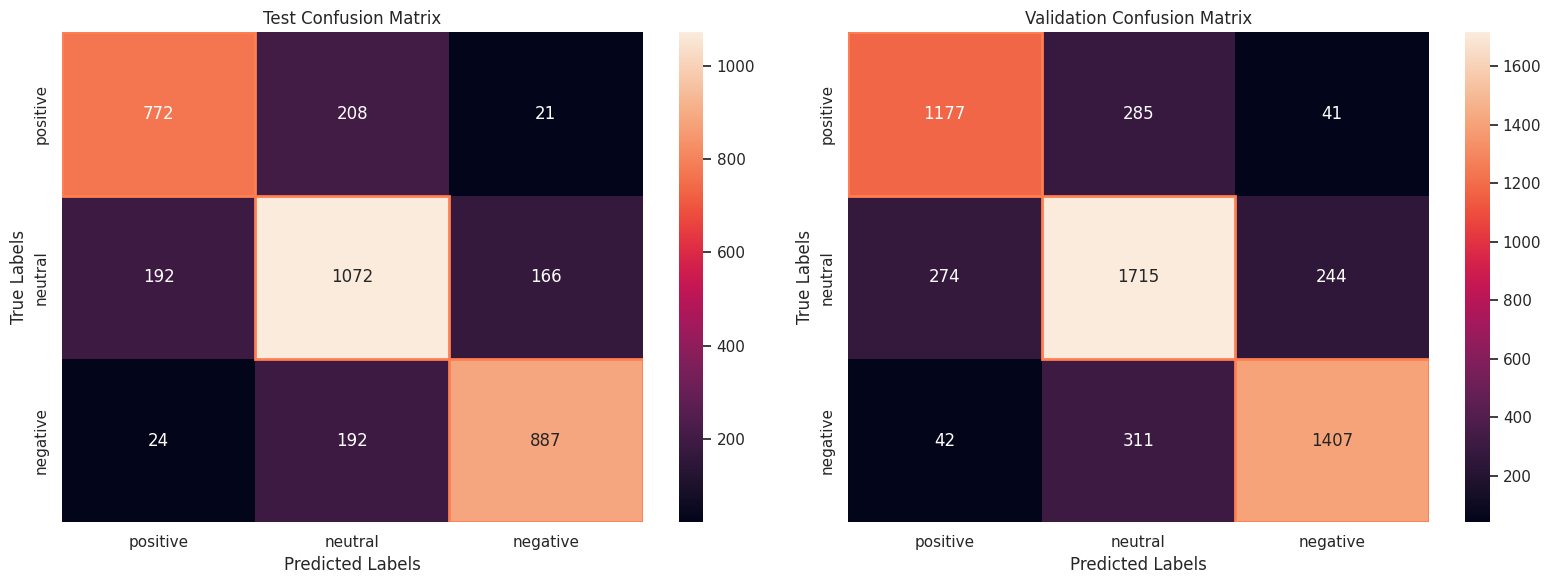

Test Classification Report:
Overall Score 77.28%
              precision    recall  f1-score   support

    positive       0.78      0.77      0.78      1001
     neutral       0.73      0.75      0.74      1430
    negative       0.83      0.80      0.81      1103

    accuracy                           0.77      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.77      0.77      0.77      3534

Validation Classification Report:
Overall Score 78.22%
              precision    recall  f1-score   support

    positive       0.79      0.78      0.79      1503
     neutral       0.74      0.77      0.75      2233
    negative       0.83      0.80      0.82      1760

    accuracy                           0.78      5496
   macro avg       0.79      0.78      0.79      5496
weighted avg       0.78      0.78      0.78      5496



In [87]:
print("After finetuning")
results.append(test_llm_model(model_llm,"Finetuned LLM"))

In [88]:
df_results = pd.DataFrame(results)
df_results

,model_name,test_accuracy,test_precision,test_recall,test_f1-score,validation_accuracy,validation_precision,validation_recall,validation_f1-score
0,Decision Tree,0.435484,0.436302,0.435484,0.435854,0.456696,0.457978,0.456696,0.457264
1,Random Forest,0.553763,0.567650,0.553763,0.544742,0.557678,0.569543,0.557678,0.548329
2,Logistic Regression,0.651104,0.652913,0.651104,0.651683,0.655568,0.658689,0.655568,0.656157
3,MLP,0.621109,0.625700,0.621109,0.621313,0.612445,0.616428,0.612445,0.612830
4,Not finetuned LLM,0.347482,0.349695,0.347482,0.257303,0.364811,0.419408,0.364811,0.275259
5,Finetuned LLM,0.772779,0.773775,0.772779,0.773160,0.782205,0.783396,0.782205,0.782607


/tmp/ipython-input-4054688041.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)
/tmp/ipython-input-4054688041.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)
/tmp/ipython-input-4054688041.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)
/tmp/ipython-input-4054688041.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)
/tmp/ipython-i

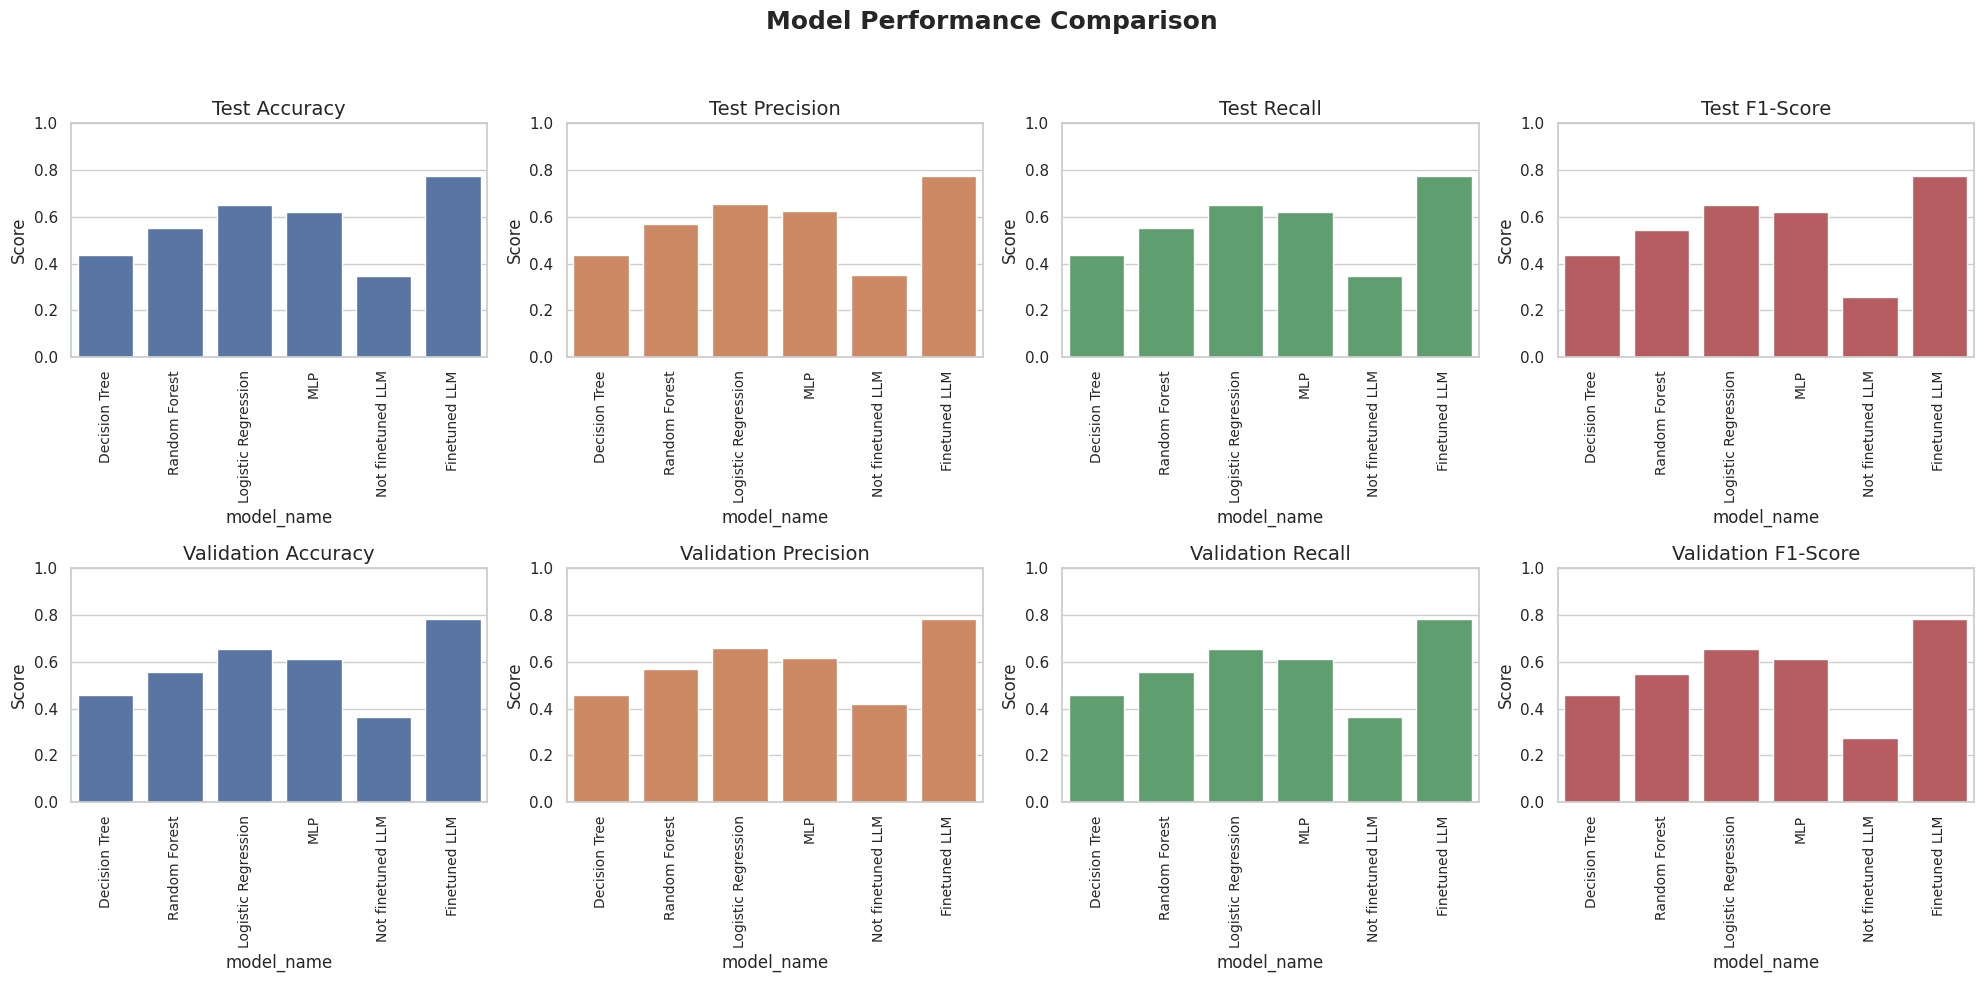

The best model is Finetuned LLM with a test accuracy of 77.28%


In [89]:
plot_model_metrics(df_results)

In [90]:
from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,  # Dropout for LoRA layers
    bias="all"
)

model_bert_lora = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model_bert_lora = get_peft_model(model_bert_lora, lora_config)
model_bert_lora.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [91]:
optimizer = Adam(model_bert_lora.parameters(), lr=0.00001)  # Fine-tuning BERT typically uses a low LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

criterion = nn.CrossEntropyLoss()

# Training settings
num_epochs = 10
patience = 3
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

In [ ]:
train_model(model_bert_lora)

Epoch 1/10 - Training: 100%|██████████| 344/344 [04:07<00:00,  1.39it/s]


Epoch [1/10], Training Loss: 1.0929, Training Accuracy: 0.4018


Epoch 1/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [1/10], Validation Loss: 1.0716, Validation Accuracy: 0.4065
Current LR: 1e-05


Epoch 2/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [2/10], Training Loss: 1.0518, Training Accuracy: 0.4405


Epoch 2/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [2/10], Validation Loss: 0.9771, Validation Accuracy: 0.5038
Current LR: 1e-05


Epoch 3/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [3/10], Training Loss: 0.9179, Training Accuracy: 0.5400


Epoch 3/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [3/10], Validation Loss: 0.8342, Validation Accuracy: 0.6055
Current LR: 1e-05


Epoch 4/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [4/10], Training Loss: 0.8218, Training Accuracy: 0.6212


Epoch 4/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [4/10], Validation Loss: 0.7690, Validation Accuracy: 0.6494
Current LR: 1e-05


Epoch 5/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [5/10], Training Loss: 0.7631, Training Accuracy: 0.6571


Epoch 5/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [5/10], Validation Loss: 0.7256, Validation Accuracy: 0.6747
Current LR: 1e-05


Epoch 6/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [6/10], Training Loss: 0.7267, Training Accuracy: 0.6840


Epoch 6/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [6/10], Validation Loss: 0.6914, Validation Accuracy: 0.6936
Current LR: 1e-05


Epoch 7/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [7/10], Training Loss: 0.6951, Training Accuracy: 0.7005


Epoch 7/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [7/10], Validation Loss: 0.6660, Validation Accuracy: 0.7103
Current LR: 1e-05


Epoch 8/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [8/10], Training Loss: 0.6755, Training Accuracy: 0.7120


Epoch 8/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [8/10], Validation Loss: 0.6431, Validation Accuracy: 0.7276
Current LR: 1e-05


Epoch 9/10 - Training: 100%|██████████| 344/344 [04:10<00:00,  1.37it/s]


Epoch [9/10], Training Loss: 0.6588, Training Accuracy: 0.7212


Epoch 9/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [9/10], Validation Loss: 0.6367, Validation Accuracy: 0.7333
Current LR: 1e-05


Epoch 10/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [10/10], Training Loss: 0.6490, Training Accuracy: 0.7244


Epoch 10/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [10/10], Validation Loss: 0.6238, Validation Accuracy: 0.7404
Current LR: 1e-05


Epoch 1/10 - Training: 100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


Epoch [1/10], Training Loss: 0.6088, Training Accuracy: 0.7424


Epoch 1/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [1/10], Validation Loss: 0.6037, Validation Accuracy: 0.7498
Current LR: 1e-05


Epoch 2/10 - Training: 100%|██████████| 344/344 [04:10<00:00,  1.37it/s]


Epoch [2/10], Training Loss: 0.6031, Training Accuracy: 0.7456


Epoch 2/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Validation loss improved. Saving model checkpoint.
Epoch [2/10], Validation Loss: 0.5921, Validation Accuracy: 0.7566
Current LR: 1e-05


Epoch 3/10 - Training:  91%|█████████ | 312/344 [03:47<00:23,  1.37it/s]

In [ ]:
results.append(test_llm_model(model_bert_lora,"llm with lora"))

In [ ]:
plot_metrics(train_loss_history,val_loss_history,train_accuracy_history,val_accuracy_history)

Q0
Analyse exploratoire des données (EDA)
Avant de mettre en place les modèles de classification, une analyse exploratoire des données a été effectuée pour mieux comprendre le dataset.

Prétraitement des textes
Les textes ont été nettoyés en supprimant les stopwords, les liens URL, et la ponctuation. Nous avons également converti les textes en minuscules et supprimé les espaces supplémentaires.

Transformation des sentiments
Les sentiments ont été convertis en trois classes : positif (2), neutre (1) et négatif (0), afin de rendre les données adaptées à la classification multi-classes.

Séparation des données
Les données ont été divisées en ensembles d'entraînement (80%) et de validation (20%), avec un ensemble de test distinct.

Visualisations des données
Longueur des tweets par sentiment : Les graphiques ont montré des variations dans la longueur des tweets en fonction des sentiments.
Distribution des sentiments par heure et âge : L'analyse des sentiments en fonction de l'heure de publication et de l'âge des utilisateurs a révélé des tendances intéressantes.
Mots fréquents par sentiment : L'examen des mots les plus fréquents a permis d'identifier des termes caractéristiques pour chaque sentiment.
ces graphes permettent de savoir si ces features sont importantes, et effectivement ils n'ont pas donné d'informations suplémentaire vu qu'ils sont eaquly distrbuted.

Distribution des sentiments
Une répartition des sentiments dans l'ensemble des données a montré un certain équilibre entre les classes.

Cette analyse a permis de mieux comprendre les données, ce qui facilitera les prochaines étapes, notamment la préparation des données et l'entraînement des modèles de classification.

Q1
Nous avons testé plusieurs modèles classiques de machine learning pour une tâche de sentiment analysis, en utilisant les embeddings de BERT pour représenter les textes. Voici les scores de test de chaque modèle :

Modèle	Score de Test
KMeans	0.35
Decision Tree	0.44
Random Forest	0.57
Logistic Regression	0.65
KNN	0.49
Analyse des Résultats :
KMeans montre un score faible (0.35), ce qui est attendu car il s'agit d'un modèle non supervisé qui regroupe les textes sans cibler directement les sentiments.
Decision Tree (0.44) et KNN (0.49) montrent des performances relativement faibles, suggérant qu'ils ne parviennent pas à exploiter efficacement les relations complexes présentes dans les embeddings BERT.
Random Forest (0.57) obtient un meilleur score, grâce à sa capacité à réduire le sur-apprentissage, mais il reste modéré.
Logistic Regression (0.65) est le modèle classique le plus performant, capturant de manière plus efficace les relations dans les embeddings BERT.
Conclusion :
La régression logistique, avec un score de test de 0.65, surpasse les autres modèles classiques. Cependant, ces scores modérés montrent que les modèles classiques sont limités pour capturer la complexité des données textuelles. Cela justifie l'utilisation de modèles avancés, comme les réseaux neuronaux et les architectures de langage, pour améliorer les performances.

Q2
question faite en code

Q3
L'analyse des performances montre que la régression logistique avec TF-IDF est le meilleur modèle parmi les approches classiques, atteignant 70,37 % de précision, juste devant le SVM linéaire (69,16 %). Ces modèles exploitent efficacement la transformation TF-IDF, qui capture bien l'importance des mots sans nécessiter de calculs complexes.

L'utilisation des embeddings BERT améliore la représentation sémantique des textes, mais les performances des modèles classiques restent en dessous de celles obtenues avec TF-IDF. La régression logistique avec embeddings BERT atteint 65 %, ce qui est inférieur à sa version avec TF-IDF, suggérant que ces représentations ne sont pas forcément adaptées aux modèles classiques sans ajustements spécifiques.

Le MLP (Multi-Layer Perceptron) atteint 63 %, un score proche de celui des modèles classiques, mais sans offrir d’amélioration significative. Son temps d'entraînement et ses besoins en ressources étant plus élevés, il n’apporte pas un avantage clair par rapport aux modèles plus simples.

Q4
Pour évaluer nos performances par rapport à un modèle de langage pré-entraîné, nous avons utilisé BERT-base-uncased, un modèle de type Large Language Model (LLM) spécialisé dans le traitement du langage naturel.

Dans un premier temps, nous avons utilisé BERT sans fine-tuning pour effectuer une classification de texte en trois classes (positif, neutre, négatif). Ce modèle pré-entraîné a obtenu un score de 40,29 %, ce qui indique qu'il n'était pas adapté à notre tâche spécifique sans ajustement supplémentaire.

Ensuite, nous avons effectué un fine-tuning de BERT sur notre jeu de données en entraînant le modèle avec un ensemble d’apprentissage et de validation bien structuré. Après plusieurs époques d’entraînement, avec l’optimisation des hyperparamètres (apprentissage à 2e-5, régulation avec ReduceLROnPlateau, et CrossEntropyLoss comme fonction de perte), nous avons observé une amélioration significative des performances. Le modèle finement ajusté a atteint une précision de 76,6 %, soit une augmentation de plus de 36 points de pourcentage par rapport à la version non fine-tunée.

Cette expérience démontre l’importance du fine-tuning des modèles pré-entraînés sur des tâches spécifiques. Alors que le modèle BERT brut capture déjà des informations linguistiques générales, son adaptation à un domaine particulier améliore considérablement ses performances. Cela confirme l’intérêt des techniques de transfert d’apprentissage dans le traitement du langage naturel et l’optimisation des modèles LLM pour des applications spécifiques.

Q5
Contrairement au texte brut qui considère les mots comme des entités isolées, BERT génère des vecteurs denses qui encodent à la fois le sens intrinsèque des mots et leurs relations contextuelles au sein de la phrase. Cette représentation vectorielle de haute dimension capture efficacement les nuances sémantiques et syntaxiques du langage.

Grâce à son architecture pré-entraînée sur des corpus massifs de textes, BERT possède une compréhension approfondie du langage. Cela lui permet de :

Gérer l'ambiguïté lexicale : différencier les multiples sens d'un mot en fonction de son contexte. Capturer les relations sémantiques complexes : identifier les liens subtils entre les mots. Reconnaître les structures grammaticales : analyser les dépendances à longue distance dans les phrases. L'utilisation des embeddings BERT améliore considérablement la qualité des représentations textuelles, ce qui se traduit par de meilleures performances dans diverses tâches de traitement du langage naturel.

Q6
BERT est conçu pour apprendre des représentations profondes et bidirectionnelles à partir de texte non annoté. Contrairement à des modèles comme OpenAI GPT, qui fonctionnent de manière unidirectionnelle (de gauche à droite), BERT prend en compte à la fois le contexte gauche et droit d'un mot. Cette bidirectionnalité est cruciale pour des tâches comme la réponse à des questions, où comprendre le contexte global est essentiel.

Architecture de BERT BERT repose sur l'architecture Transformer, plus précisément sur une version multi-couches et bidirectionnelle. Il existe deux versions principales:
BERTBASE : 12 couches, 768 unités cachées, 12 têtes d'attention, 110 millions de paramètres.

BERTLARGE : 24 couches, 1024 unités cachées, 16 têtes d'attention, 340 millions de paramètres.

BERT utilise des embeddings WordPiece et intègre des informations sur les tokens, les segments (pour distinguer les phrases) et les positions des mots.

Pré-entraînement BERT est pré-entraîné sur deux tâches principales :
Masked Language Model (MLM) : 15% des mots sont masqués aléatoirement, et le modèle doit les prédire en fonction du contexte. Cela permet à BERT de comprendre le sens des mots dans leur contexte global.

Next Sentence Prediction (NSP) : Le modèle apprend à prédire si une phrase suit une autre, ce qui l'aide à saisir les relations entre les phrases.

Fine-tuning Après le pré-entraînement, BERT peut être adapté à des tâches spécifiques (comme la classification de texte ou la réponse à des questions) avec peu de modifications. Le fine-tuning est rapide et nécessite peu de ressources.

Performances BERT a battu des records sur 11 tâches NLP, notamment sur les benchmarks GLUE et SQuAD. Par exemple, sur SQuAD v1.1, BERT atteint un score F1 de 93.2, surpassant les modèles précédents. Il excelle également dans des tâches comme l'analyse de sentiments.

Source: https://paperswithcode.com/paper/bert-pre-training-of-deep-bidirectional

Q7 :
LoRA (Low-Rank Adaptation) est une méthode efficace pour le fine-tuning des modèles de langage de grande taille (LLM). Plutôt que d’ajuster directement tous les poids du modèle, LoRA insère des couches d’adaptation de faible rang qui capturent les nouvelles informations sans modifier la structure principale du modèle pré-entraîné. Cela réduit considérablement la consommation mémoire et accélère le fine-tuning, ce qui est particulièrement utile pour les LLM.